# STAT3009 Project 1
# SID:1155152095(T = 2095)
# Name: Lam Wai Chiu

## Import package

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import KFold
import itertools
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tabulate import tabulate

## Load the developed methods

In [2]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

def adjust(pred_rating, score_min, score_max):
    pred_rating_adjusted = pred_rating.copy()
    pred_rating_adjusted[pred_rating > score_max] = score_max
    pred_rating_adjusted[pred_rating < score_min] = score_min
    return pred_rating_adjusted

def print_T(t,temp_test_pair,pred_rating):
	print('test_pair:' ,temp_test_pair[t])
	print('pred_rating:',pred_rating[t])

def print_top5(t,temp_test_pair,pred):
	user_index=np.where(temp_test_pair[:,0]==temp_test_pair[t,0])[0]
	item_index=pred_rating[user_index].argsort()[-5:][::-1]
	list1=temp_test_pair[user_index,1][item_index]
	list2=pred_rating[user_index][item_index]
	result = pd.DataFrame(list(zip(list1, list2)), columns =['item', 'rating'])
	print(result.sort_values(by='rating', ascending=False).to_string(index=False))

def get_id(id,temp_id):
	temp=id
	uniq=np.unique(temp_id)
	for i in range(len(id)):
		temp[i]=np.where(id[i]==uniq)[0][0]
	return temp


class LFM(object):

    def __init__(self, n_user, n_item, lam=.001, K=10, iterNum=10, tol=1e-4, verbose=1):
        self.P = np.ones([n_user, K]) # to converge faster, user np.ones instead of np.random.randn
        self.Q = np.ones([n_item, K])
        # self.index_item = []
        # self.index_user = []
        self.n_user = n_user
        self.n_item = n_item
        self.lam = lam
        self.K = K
        self.iterNum = iterNum
        self.tol = tol
        self.verbose = verbose

    def fit(self, train_pair, train_rating):
        diff, tol = 1., self.tol
        n_user, n_item, n_obs = self.n_user, self.n_item, len(train_pair)
        K, iterNum, lam = self.K, self.iterNum, self.lam
        ## store user/item index set
        self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
        self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
        if self.verbose:
            print('Fitting Reg-LFM: K: %d, lam: %.5f' %(K, lam))
        for i in range(iterNum):
            ## item update
            score_old = self.rmse(test_pair=train_pair, test_rating=train_rating)
            for item_id in range(n_item):
                index_item_tmp = self.index_item[item_id]
                if len(index_item_tmp) == 0:
                    self.Q[item_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_item_tmp:
                    ## double-check
                    if item_id != train_pair[record_ind][1]:
                        raise ValueError('the item_id is waring in updating Q!')
                    user_id, rating_tmp = train_pair[record_ind][0], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.P[user_id,:], self.P[user_id,:])
                    sum_pu = sum_pu + rating_tmp * self.P[user_id,:]                    
                self.Q[item_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            
            for user_id in range(n_user):
                index_user_tmp = self.index_user[user_id]
                if len(index_user_tmp) == 0:
                    self.P[user_id,:] = 0.
                    continue
                sum_pu, sum_matrix = np.zeros((K)), np.zeros((K, K))
                for record_ind in index_user_tmp:
                    ## double-check
                    if user_id != train_pair[record_ind][0]:
                        raise ValueError('the user_id is waring in updating P!')
                    item_id, rating_tmp = train_pair[record_ind][1], train_rating[record_ind]
                    sum_matrix = sum_matrix + np.outer(self.Q[item_id,:], self.Q[item_id,:])
                    sum_pu = sum_pu + rating_tmp * self.Q[item_id,:]                    
                self.P[user_id,:] = np.dot(np.linalg.inv(sum_matrix + lam*n_obs*np.identity(K)), sum_pu)
            # compute the new rmse score
            score_new = self.rmse(test_pair=train_pair, test_rating=train_rating)
            diff = abs(score_new - score_old) / score_old
            if self.verbose:
                print("Reg-LFM: ite: %d; diff: %.3f RMSE: %.3f" %(i, diff, score_new))
            if(diff < tol):
                break

    def predict(self, test_pair):
        # predict ratings for user-item pairs
        pred_rating = [np.dot(self.P[line[0]], self.Q[line[1]]) for line in test_pair]
        return np.array(pred_rating)
    
    def rmse(self, test_pair, test_rating):
        # report the rmse for the fitted `LFM`
        pred_rating = self.predict(test_pair=test_pair)
        return np.sqrt( np.mean( (pred_rating - test_rating)**2) )

In [3]:
def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

# baseline methods
class glb_mean(object):
	def __init__(self):
		self.glb_mean = 0
	
	def fit(self, train_rating):
		self.glb_mean = np.mean(train_rating)
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))
		pred = pred*self.glb_mean
		return pred
    
class user_mean(object):
	def __init__(self, n_user):
		self.n_user = n_user
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for u in range(self.n_user):
			ind_train = np.where(train_pair[:,0] == u)[0]
			if len(ind_train) == 0:
				self.user_mean[u] = self.glb_mean
			else:
				self.user_mean[u] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.user_mean[user_tmp]
			j = j + 1
		return pred

class item_mean(object):
	def __init__(self, n_item):
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		for i in range(self.n_item):
			ind_train = np.where(train_pair[:,1] == i)[0]
			if len(ind_train) == 0:
				self.item_mean[i] = self.glb_mean
			else:
				self.item_mean[i] = train_rating[ind_train].mean()
	
	def predict(self, test_pair):
		pred = np.ones(len(test_pair))*self.glb_mean
		j = 0
		for row in test_pair:
			user_tmp, item_tmp = row[0], row[1]
			pred[j] = self.item_mean[item_tmp]
			j = j + 1
		return pred


In [4]:
# define class for correlation based RS
from numpy.linalg import norm
from scipy.sparse import lil_matrix

class cor_rs_user(object):
	def __init__(self, n_user, n_item):
		self.n_user = n_user
		self.n_item = n_item
		self.glb_mean = 0.
		self.user_mean = np.zeros(n_user)
		self.S = lil_matrix((n_user, n_user))
		self.index_item = []
		self.index_user = []
		self.min_co = 3
	
	def cossim(self, index_u, index_v, train_pair, train_rating):
		item_u = train_pair[index_u][:,1]
		item_v = train_pair[index_v][:,1]
		# find co-rating items by `set`
		item_co = list(set(item_u).intersection(set(item_v)))
		if len(item_co) < self.min_co:
			# a tuning parameter
			return 0.0
		else:
			# find the co-rating vectors by using `np.isin`
			vec_u, vec_v = train_rating[index_u], train_rating[index_v]
			ind_co_u = [np.where(item_u == item_co_tmp)[0][0] for item_co_tmp in item_co]
			ind_co_v = [np.where(item_v == item_co_tmp)[0][0] for item_co_tmp in item_co]
			vec_co_u, vec_co_v = vec_u[ind_co_u], vec_v[ind_co_v]			
			return np.dot(vec_co_u, vec_co_v) / (norm(vec_co_u)+1e-5) / (norm(vec_co_v)+1e-5)
	
	def sim_mat(self, train_pair, train_rating):
		self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
		self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
		for u in range(self.n_user):
			for v in range(u):
				if (len(self.index_user[u]) == 0) or (len(self.index_user[v]) == 0):
					continue
				weight_tmp = self.cossim(self.index_user[u],self.index_user[v],train_pair,train_rating)
				if weight_tmp > 0:
					self.S[u,v] = weight_tmp
		self.S = self.S + self.S.T
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		# use another class to predict the user mean
		user_ave_method = user_mean(self.n_user)
		user_ave_method.fit(train_pair, train_rating)
		self.user_mean = user_ave_method.user_mean
		self.sim_mat(train_pair, train_rating)
	
	def predict(self, test_pair, train_pair, train_rating, top=10):
		pred = np.zeros(len(test_pair))
		for j in range(len(test_pair)):
			user_tmp, item_tmp = test_pair[j,0], test_pair[j,1]
			index_tmp = self.index_item[item_tmp]
			rated_users = train_pair[index_tmp][:,0]
			rated_ratings = train_rating[index_tmp]
			sim_weight = self.S[user_tmp, rated_users].toarray()[0]
			## only keep top 10 closest users
			top_ind = sim_weight.argsort()[-top:][::-1]
			sim_weight_knn = np.zeros(len(sim_weight))
			sim_weight_knn[top_ind] = sim_weight[top_ind]
			if (len(rated_users) == 0) or (max(sim_weight_knn) == 0):
				# if no rated users or no similar users
				pred[j] = self.user_mean[user_tmp]
			else:
				pred[j] = np.sum(sim_weight_knn*rated_ratings) / np.sum(sim_weight_knn)
		return pred


class cor_rs_item(object):
	def __init__(self, n_user, n_item):
		self.n_user = n_user
		self.n_item = n_item
		self.glb_mean = 0.
		self.item_mean = np.zeros(n_item)
		self.S = lil_matrix((n_item, n_item))
		self.index_item = []
		self.index_user = []
		self.min_co = 3

	def cossim(self, index_i, index_j, train_pair, train_rating):
		# index_u = np.where(train_pair[:,0] == u)[0]
		# index_v = np.where(train_pair[:,0] == v)[0]
		user_i = train_pair[index_i][:,0]
		user_j = train_pair[index_j][:,0]
		# find co-rating items by `set`
		user_co = list(set(user_i).intersection(set(user_j)))
		if len(user_co) < self.min_co:
			# a tuning parameter
			return 0.0
		else:
			# find the co-rating vectors by using `np.where`
			vec_i, vec_j = train_rating[index_i], train_rating[index_j]
			ind_co_i = [np.where(user_i == user_co_tmp)[0][0] for user_co_tmp in user_co]
			ind_co_j = [np.where(user_j == user_co_tmp)[0][0] for user_co_tmp in user_co]
			vec_co_i, vec_co_j = vec_i[ind_co_i], vec_j[ind_co_j]
			return np.dot(vec_co_i, vec_co_j) / (norm(vec_co_i)+1e-5) / (norm(vec_co_j)+1e-5)
	
	def sim_mat(self, train_pair, train_rating):
		self.index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
		self.index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
		for i in range(self.n_item):
			for j in range(i):
				if (len(self.index_item[i]) == 0) or (len(self.index_item[j]) == 0):
					continue
				weight_tmp = self.cossim(self.index_item[i],self.index_item[j],train_pair,train_rating)
				if weight_tmp > 0:
					self.S[i,j] = weight_tmp
		self.S = self.S + self.S.T
	
	def fit(self, train_pair, train_rating):
		self.glb_mean = train_rating.mean()
		# use another class to predict the item mean
		item_ave_method = item_mean(self.n_item)
		item_ave_method.fit(train_pair, train_rating)
		self.item_mean = item_ave_method.item_mean
		self.sim_mat(train_pair, train_rating)
	
	def predict(self, test_pair, train_pair, train_rating, top=10):
		pred = np.zeros(len(test_pair))
		for j in range(len(test_pair)):
			user_tmp, item_tmp = test_pair[j,0], test_pair[j,1]
			index_tmp = self.index_user[user_tmp]
			rated_items = train_pair[index_tmp][:,1]
			rated_ratings = train_rating[index_tmp]
			sim_weight = self.S[item_tmp, rated_items].toarray()[0]
			## only keep top 10 closest users
			top_ind = sim_weight.argsort()[-top:][::-1]
			sim_weight_knn = np.zeros(len(sim_weight))
			sim_weight_knn[top_ind] = sim_weight[top_ind]
			if (len(rated_items) == 0) or (max(sim_weight_knn) == 0):
				# if no rated items or no similar items
				pred[j] = self.item_mean[item_tmp]
			else:
				pred[j] = np.sum(sim_weight_knn*rated_ratings) / np.sum(sim_weight_knn)
		return pred

def rmse(true, pred):
	return np.sqrt(np.mean((pred - true)**2))

In [5]:
class LFM_CV(object):

	def __init__(self, n_user, n_item, cv=5,
				lams=[.000001,.0001,.001,.01], 
				Ks=[3,5,10,20], 
				iterNum=10, tol=1e-4):
		# self.index_item = []
		# self.index_user = []
		self.n_user = n_user
		self.n_item = n_item
		self.cv = cv
		self.lams = lams
		self.Ks = Ks
		self.iterNum = iterNum
		self.tol = tol
		self.best_model = {}
		self.cv_result = {'K': [], 'lam': [], 'train_rmse': [], 'valid_rmse': []}

	def grid_search(self, train_pair, train_rating):
		## generate all comb of `K` and `lam`
		kf = KFold(n_splits=self.cv, shuffle=True)
		for (K,lam) in itertools.product(self.Ks, self.lams):
			train_rmse_tmp, valid_rmse_tmp = 0., 0.
			for train_index, valid_index in kf.split(train_pair):
				# produce training/validation sets
				train_pair_cv, train_rating_cv = train_pair[train_index], train_rating[train_index]
				valid_pair_cv, valid_rating_cv = train_pair[valid_index], train_rating[valid_index]
				# fit the model based on CV data
				model_tmp = LFM(self.n_user, self.n_item, K=K, lam=lam, verbose=0)
				model_tmp.fit(train_pair=train_pair_cv, train_rating=train_rating_cv)
				train_rmse_tmp_cv = model_tmp.rmse(test_pair=train_pair_cv, test_rating=train_rating_cv)
				valid_rmse_tmp_cv = model_tmp.rmse(test_pair=valid_pair_cv, test_rating=valid_rating_cv)
				train_rmse_tmp = train_rmse_tmp + train_rmse_tmp_cv / self.cv
				valid_rmse_tmp = valid_rmse_tmp + valid_rmse_tmp_cv / self.cv
				print('%d-Fold CV for K: %d; lam: %.5f: train_rmse: %.3f, valid_rmse: %.3f' 
						%(self.cv, K, lam, train_rmse_tmp_cv, valid_rmse_tmp_cv))
			self.cv_result['K'].append(K)
			self.cv_result['lam'].append(lam)
			self.cv_result['train_rmse'].append(train_rmse_tmp)
			self.cv_result['valid_rmse'].append(valid_rmse_tmp)
		self.cv_result = pd.DataFrame.from_dict(self.cv_result)
		best_ind = self.cv_result['valid_rmse'].argmin()
		self.best_model = self.cv_result.loc[best_ind]
	
	def plot_grid(self, data_source='valid'):
		sns.set_theme()
		if data_source == 'train':
			cv_pivot = self.cv_result.pivot("K", "lam", "train_rmse")
		elif data_source == 'valid':
			cv_pivot = self.cv_result.pivot("K", "lam", "valid_rmse")
		else:
			raise ValueError('data_source must be train or valid!')
		sns.heatmap(cv_pivot, annot=True, fmt=".3f", linewidths=.5, cmap="YlGnBu")
		plt.show()

## Process the data

In [6]:
item_feat = pd.read_csv("data/item_feats.csv")
user_feat = pd.read_csv("data/user_feats.csv")
test_pair = pd.read_csv("data/test_pair.csv")
train_rating = pd.read_csv("data/train_rating.csv")
sub = pd.read_csv('predict/sample_submission.csv')

In [7]:
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(np.append(train_rating['UserId'], test_pair["UserId"]), user_feat["UserId"]))

user_feat['UserId'] = le_user.transform(user_feat["UserId"])
test_pair["UserId"] = le_user.transform(test_pair["UserId"])
train_rating['UserId'] = le_user.transform(train_rating["UserId"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(np.append(train_rating['ItemId'], test_pair["ItemId"]), item_feat["ItemId"]))

item_feat['ItemId'] = le_item.transform(item_feat["ItemId"])
test_pair["ItemId"] = le_item.transform(test_pair["ItemId"])
train_rating['ItemId'] = le_item.transform(train_rating["ItemId"])

In [8]:
item_feat=item_feat.values
user_feat=user_feat.values
train_pair=train_rating[['UserId', 'ItemId']].values
test_pair=test_pair.values
rating = train_rating['rating'].values

n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

In [9]:
temp_train_user=np.zeros((len(train_pair[:,0]), 4))
temp_train_item=np.zeros((len(train_pair[:,0]), 3))

temp_test_user=np.zeros((len(test_pair[:,0]), 4))
temp_test_item=np.zeros((len(test_pair[:,0]), 3))

In [10]:
user_feat[0,1:5]

array([  nan, 5233.,  982.,  330.])

In [117]:
temp_test_user[:,1].reshape(-1, 1)

array([[6508.],
       [2093.],
       [2243.],
       ...,
       [5320.],
       [3214.],
       [6508.]])

In [11]:
for i in range(0,len(train_pair[:,0])):
    temp_train_user[i,:]=user_feat[np.where(train_pair[i,0]==user_feat[:,0])[0][0],1:5]
    temp_train_item[i,:]=item_feat[np.where(train_pair[i,1]==item_feat[:,0])[0][0],1:4]

for i in range(0,len(test_pair[:,0])):
    temp_test_user[i,:]=user_feat[np.where(test_pair[i,0]==user_feat[:,0])[0][0],1:5]
    temp_test_item[i,:]=item_feat[s[0][0],1:4]


(array([7131], dtype=int64),)

In [12]:
train=np.concatenate((temp_train_user, temp_train_item), axis=1)
test=np.concatenate((temp_test_user, temp_test_item), axis=1)


In [29]:
sum(np.isnan(train[:,0]))

13264

In [54]:
len(train[:,0])

40321

In [34]:
rating_exist=np.zeros((sum(np.isnan(train[:,0])), 1))
train0exist=np.zeros((sum(np.isnan(train[:,0])), 1))

for i in range(0,sum(np.isnan(train[:,0]))):
    rating_exist[i]=rating[np.where(np.isnan(train[:,0])==0)[0][i]]
    
for i in range(0,sum(np.isnan(train[:,0]))):
    train0exist[i]=train[np.where(np.isnan(train[:,0])==0)[0][i],0]

In [72]:
rating_exist=np.zeros((sum(np.isnan(train[:,0])), 1))
a=[]

for i in range(0,len(user_feat)):
    b=rating[np.where(train_pair[:,0]==i)[0]]
    np.append(a,b)

In [82]:
rating[np.where(test_pair[:,0]==5)[0]]

array([5., 0., 0., 4., 0., 0., 0.])

In [105]:
len(list(set(np.unique(train_pair[:,1])) - set(np.unique(test_pair[:,1]))))

13589

In [96]:
np.unique(test_pair[:,0])

array([    5,     9,    23, ..., 26977, 26991, 26999])

In [90]:
len(test_pair)

19860

In [80]:
np.where(train_pair[:,0]==3)

(array([], dtype=int64),)

In [63]:
a

array([], dtype=float64)

In [36]:
rating_exist,train0exist


(array([[0. ],
        [0. ],
        [0. ],
        ...,
        [4.5],
        [4.5],
        [0. ]]),
 array([[4.01914372],
        [3.25193984],
        [4.19756725],
        ...,
        [3.77556681],
        [3.74434382],
        [3.73653779]]))

In [37]:
np.column_stack((rating_exist,train0exist))

array([[0.        , 4.01914372],
       [0.        , 3.25193984],
       [0.        , 4.19756725],
       ...,
       [4.5       , 3.77556681],
       [4.5       , 3.74434382],
       [0.        , 3.73653779]])

In [47]:
plt.plot(train[:,7], rating, 'o', color='black');

IndexError: index 7 is out of bounds for axis 1 with size 7

In [ ]:
plt.plot(train0exist, rating_exist, 'o', color='black');

In [ ]:
inds = np.where(np.isnan(train[:,0]))
train[inds,0]=np.nanmean(train[np.isfinite(train[:,0]),0])

inds_test = np.where(np.isnan(test[:,0]))
test[inds_test,0]=np.nanmean(test[np.isfinite(test[:,0]),0])

train[np.isinf(train[:,0]),0]=-3
train[np.isinf(train[:,5]),5]=2

test[np.isinf(test[:,0]),0]=-3
test[np.isinf(test[:,5]),5]=2

In [108]:
temp_test_user[:,1].reshape(-1, 1)

array([[6508.],
       [2093.],
       [2243.],
       ...,
       [5320.],
       [3214.],
       [6508.]])

In [13]:
np.isinf(train[:,0])

array([False, False, False, ..., False, False, False])

In [14]:
min(train[np.isfinite(train[:,5]),5])

2.0

In [15]:
rate = [str(rating) for rating in rating]

In [16]:
rate


['0.0',
 '0.0',
 '0.0',
 '0.0',
 '4.0',
 '0.0',
 '0.0',
 '0.0',
 '4.0',
 '0.0',
 '2.0',
 '0.0',
 '4.5',
 '4.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '3.0',
 '2.5',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '4.5',
 '5.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '5.0',
 '0.0',
 '0.0',
 '3.5',
 '5.0',
 '0.0',
 '3.5',
 '0.0',
 '4.0',
 '0.0',
 '4.5',
 '2.5',
 '3.0',
 '0.0',
 '5.0',
 '0.0',
 '4.5',
 '3.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '0.0',
 '2.5',
 '4.0',
 '0.0',
 '5.0',
 '4.0',
 '0.0',
 '4.5',
 '4.0',
 '0.0',
 '3.5',
 '0.0',
 '4.5',
 '0.0',
 '3.5',
 '4.0',
 '0.0',
 '0.0',
 '2.5',
 '0.0',
 '4.5',
 '0.0',
 '0.0',
 '4.5',
 '0.0',
 '0.0',
 '0.0',
 '3.5',
 '0.0',
 '5.0',
 '0.0',
 '3.5',
 '5.0',
 '0.0',
 '5.0',
 '0.0',
 '5.0',
 '4.5',
 '4.0',
 '0.0',
 '0.0',
 '4.5',
 '0.0',
 '0.0',
 '5.0',
 '3.5',
 '4.0',
 '4.0',
 '0.0',
 '3.5',
 '2.5',
 '0.0',
 '0.0',
 '5.0',
 '1.5',
 '5.0',
 '3.5',
 '3.5',
 '3.5',
 '0.0',
 '0.0',
 '2.5',


In [21]:
import scipy as sp
from scipy.stats import chi2

def mahalanobis_method(df):
    #M-Distance
    x_minus_mu = df - np.mean(df)
    cov = np.cov(df.values.T)                           #Covariance
    inv_covmat = sp.linalg.inv(cov)                     #Inverse covariance
    left_term = np.dot(x_minus_mu, inv_covmat) 
    mahal = np.dot(left_term, x_minus_mu.T)
    md = np.sqrt(mahal.diagonal())
    
    #Flag as outlier
    outlier = []
    #Cut-off point
    C = np.sqrt(chi2.ppf((1-0.001), df=df.shape[1]))    #degrees of freedom = number of variables
    for index, value in enumerate(md):
        if value > C:
            outlier.append(index)
        else:
            continue
    return outlier, md

In [47]:
df=pd.DataFrame(np.column_stack((train,rating)))

In [48]:
outlier, md=mahalanobis_method(df)

In [49]:
outlier

[68,
 208,
 272,
 286,
 425,
 507,
 549,
 556,
 565,
 671,
 679,
 709,
 735,
 745,
 788,
 809,
 855,
 866,
 868,
 1048,
 1161,
 1169,
 1189,
 1190,
 1203,
 1225,
 1260,
 1286,
 1336,
 1370,
 1428,
 1435,
 1448,
 1461,
 1540,
 1581,
 1722,
 1746,
 1750,
 1810,
 1852,
 1927,
 1948,
 2052,
 2168,
 2208,
 2218,
 2253,
 2269,
 2383,
 2428,
 2511,
 2518,
 2556,
 2559,
 2709,
 2822,
 2844,
 2850,
 2940,
 2953,
 3016,
 3109,
 3169,
 3183,
 3208,
 3350,
 3352,
 3353,
 3434,
 3464,
 3465,
 3481,
 3549,
 3597,
 3697,
 3769,
 3792,
 3799,
 3815,
 3898,
 3929,
 3933,
 4023,
 4065,
 4207,
 4313,
 4338,
 4343,
 4360,
 4372,
 4383,
 4425,
 4479,
 4502,
 4509,
 4511,
 4520,
 4581,
 4641,
 4700,
 4715,
 4777,
 4811,
 4848,
 4928,
 4975,
 5047,
 5057,
 5070,
 5208,
 5221,
 5223,
 5233,
 5267,
 5312,
 5358,
 5547,
 5550,
 5601,
 5607,
 5652,
 5676,
 5684,
 5713,
 5732,
 5736,
 5788,
 5872,
 5883,
 5887,
 5892,
 5894,
 5936,
 5970,
 5995,
 6033,
 6036,
 6064,
 6159,
 6195,
 6220,
 6250,
 6430,
 6434,
 6446

In [53]:
train=np.delete(train, outlier, 0)


In [54]:
rate=np.delete(rate, outlier, 0)

In [56]:
len(rate)

39422

In [57]:
import pandas as pd
import numpy as np
import time
import gc
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn import tree
from sklearn.metrics import roc_curve, roc_auc_score
import category_encoders as ce
import matplotlib.pyplot as plt

In [58]:
# RandomForestClassifier
random_state=3009
RandomForest = Pipeline([('rf', RandomForestClassifier(n_jobs=-1,random_state=random_state))])

# DecisionTreeClassifier
DecisionTree = Pipeline([('dt', tree.DecisionTreeClassifier(max_features='auto',random_state=random_state))])

# Set number of Cross Validation
cv = StratifiedKFold(shuffle=True, n_splits=5,random_state=random_state)

# Set parameters for RandomForestClassifier and DecisionTreeClassifier
rf_params = [{  'rf__criterion': ['entropy'],
                'rf__min_samples_leaf': [80, 100],
                'rf__max_depth': [25, 27],
                'rf__min_samples_split': [3, 5],
                'rf__n_estimators' : [50, 60]}]

dt_params = [{  'dt__max_depth': [8, 10],
                'dt__min_samples_leaf': [1, 3, 5, 7]}]

#  Set parameters for Grid Search of RandomForestClassifier and DecisionTreeClassifier
gs_rf = GridSearchCV(RandomForest, param_grid=rf_params,
                     scoring='accuracy', cv=cv)

gs_dt = GridSearchCV(DecisionTree, param_grid=dt_params,
                     scoring='accuracy', cv=cv)

# Models used
model_used = [gs_rf, gs_dt]
model_name = { 0:'RandomForest', 1:'DecisionTree'}

In [59]:
# Set temp
acc_rate = {}
models = []

# Record the time used, accuracy rate and ROC rate
for index, model in enumerate(model_used):
        start = time.time()
        print('Using {} model'.format(model_name[index]))
        model.fit(train, rate)
        print('traing accuracy rate is {}'.format(model.best_score_))
        print(model.predict_proba(test))

Using RandomForest model
traing accuracy rate is 0.572167844654272
[[5.56343798e-01 1.48806667e-03 2.00173832e-03 ... 9.47141331e-02
  8.62799182e-02 9.86771513e-02]
 [5.90928781e-01 3.66903166e-04 1.50102506e-03 ... 1.05320747e-01
  6.72191773e-02 6.16086112e-02]
 [8.02197332e-01 1.24969764e-03 1.18680331e-03 ... 4.56531912e-02
  4.71538983e-02 3.74955443e-02]
 ...
 [7.23027922e-01 4.03823859e-03 1.31390134e-03 ... 6.54350451e-02
  4.88434394e-02 7.16163766e-02]
 [7.12080785e-01 1.30208333e-04 2.07768865e-03 ... 8.11728012e-02
  4.95301142e-02 4.95013239e-02]
 [5.24647293e-01 3.26672460e-03 3.83510817e-03 ... 1.13747598e-01
  9.34473369e-02 1.03854442e-01]]
Using DecisionTree model
traing accuracy rate is 0.5719142081423507
[[0.53790614 0.00192539 0.00433213 ... 0.10902527 0.07533093 0.06594465]
 [0.72988506 0.         0.         ... 0.06896552 0.04022989 0.03448276]
 [0.61053361 0.0010395  0.001386   ... 0.08835759 0.06999307 0.07761608]
 ...
 [0.59475655 0.00374532 0.         ... 0.

In [60]:
gs_rf.fit(train, rate)
gs_rf.predict(test)


array(['0.0', '0.0', '0.0', ..., '0.0', '0.0', '0.0'], dtype='<U3')

In [61]:
pred_rf=gs_rf.predict(test)
sub['rating'] = pred_rf
sub.to_csv('predict/pred_rf.csv', index=False)

In [62]:
rating = train_rating['rating'].values
rating=np.delete(rating, outlier, 0)

In [63]:
from sklearn.ensemble import RandomForestRegressor
regressor = RandomForestRegressor(n_estimators = 500, random_state = 3009)
regressor.fit(train,rating)
pred_reg=regressor.predict(test)

In [68]:
max(pred_rf)

'5.0'

In [82]:
sum(pred_rf==["3.0"])

0

In [67]:
max(pred_reg)

4.996

In [66]:
sub['rating'] = pred_reg
sub.to_csv('predict/pred_reg.csv', index=False)

In [ ]:
dtrain = pd.read_csv("data/item_feat.csv")
test_pair = pd.read_csv("data/test_pair.csv")
sub = pd.read_csv('predict/sample_submission.csv')

In [28]:
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(dtrain['user_id'], dtest["user_id"]))
dtrain['user_id'] = le_user.transform(dtrain["user_id"])
dtest["user_id"] = le_user.transform(dtest["user_id"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(dtrain['item_id'], dtest["item_id"]))
dtrain["item_id"] = le_item.transform(dtrain["item_id"])
dtest["item_id"] = le_item.transform(dtest["item_id"])

,UserId,ItemId,rating
0,A22818,70621F,0.0
1,36B488,16553B,0.0
2,AB1C55,035CDE,0.0
3,9FEADA,ABE1FA,0.0
4,3C5A14,D96304,4.0
...,...,...,...
40316,74852D,FABCCC,0.0
40317,8EBB7E,B04CEA,0.0
40318,57849A,3B1133,0.0
40319,06FA94,34FAD1,0.0


In [5]:
dtrain = pd.read_csv("data/item_feat.csv")
dtest = pd.read_csv("data/test.csv")
sub = pd.read_csv('predict/sample_submission.csv')

## mapping 
from sklearn import preprocessing
le_user = preprocessing.LabelEncoder()
le_user.fit(np.append(dtrain['user_id'], dtest["user_id"]))
dtrain['user_id'] = le_user.transform(dtrain["user_id"])
dtest["user_id"] = le_user.transform(dtest["user_id"])

le_item = preprocessing.LabelEncoder()
le_item.fit(np.append(dtrain['item_id'], dtest["item_id"]))
dtrain["item_id"] = le_item.transform(dtrain["item_id"])
dtest["item_id"] = le_item.transform(dtest["item_id"])

# train_pair, train_rating
train_pair = dtrain[['user_id', 'item_id']].values
train_rating = dtrain['rating'].values

# test_pair
test_pair = dtest[['user_id', 'item_id']].values
n_user, n_item = max(train_pair[:,0].max(), test_pair[:,0].max())+1, max(train_pair[:,1].max(), test_pair[:,1].max())+1

## Exploratory data analysis (EDA)
- User rating of the items

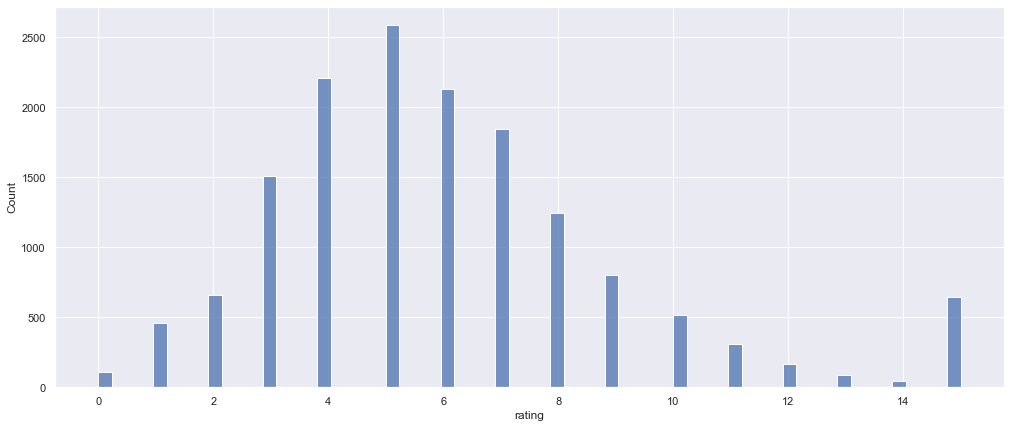

In [7]:
sns.set_theme()
## histograms of rating 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="rating")
plt.show()

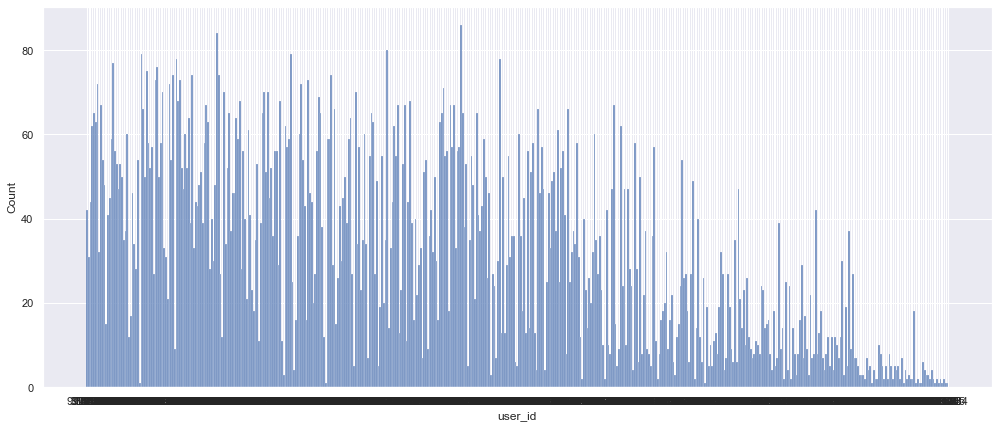

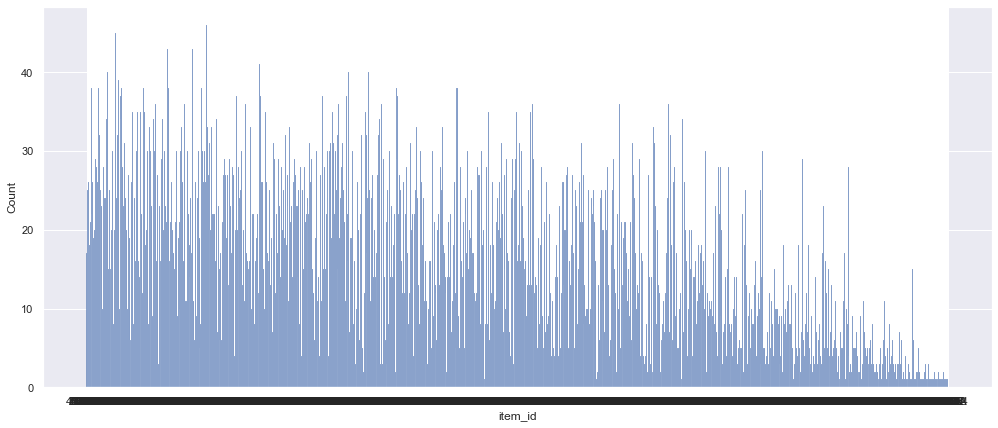

In [74]:
## histograms of user 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="user_id")
plt.show()
## histograms of item 
plt.figure(1, figsize=(17, 7))
sns.histplot(data=dtrain, x="item_id")
plt.show()

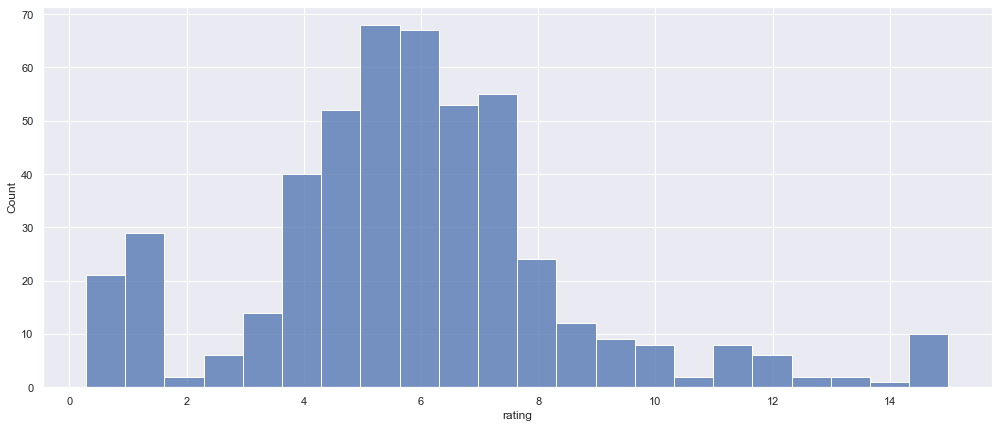

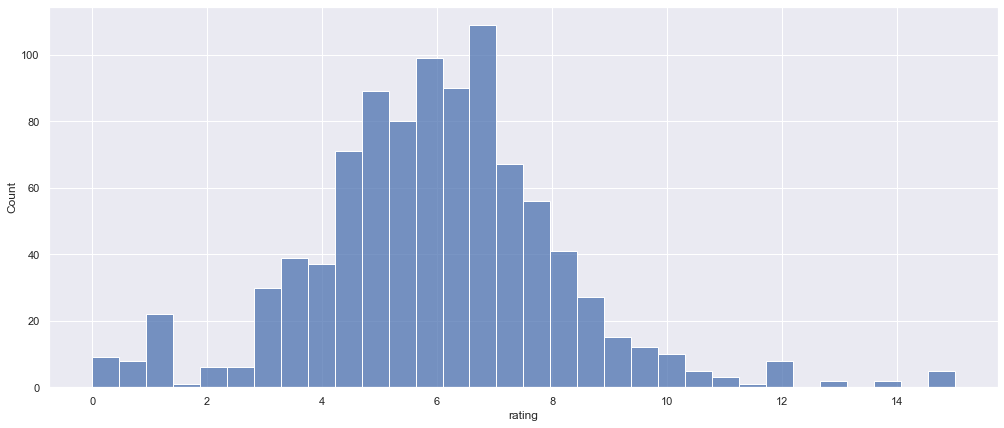

In [73]:
# histgrams for averaged ratings for users/items
plt.figure(1, figsize=(17, 7))
sns.histplot(dtrain.groupby('user_id')['rating'].mean())
plt.show()
plt.figure(1, figsize=(17, 7))
sns.histplot(dtrain.groupby('item_id')['rating'].mean())
plt.show()

In [77]:
## Find Top-20 highest rating items
pd.DataFrame(dtrain.groupby('item_id')['rating'].mean().sort_values(ascending = False)[:20], columns =['rating'])

,rating
item_id,
6CC285,15.000000
12B649,15.000000
984286,15.000000
A34883,15.000000
46615F,15.000000
00A6C3,14.000000
1F195C,14.000000
854152,13.000000
1BD1BC,13.000000


         Count
item_id       
48A3FB      46
C29496      45
248973      43
FEAECC      43
43688C      42
78FEAC      42
5DC14E      41
954956      40
4662D7      40
9BD8B5      40
AFA01C      39
B02D4E      38
52B3D7      38
1FA901      38
1D2EF8      38
1A8CEA      38
9D6BE2      38
EAB8BB      38
93F0A2      38
7DBBE3      38


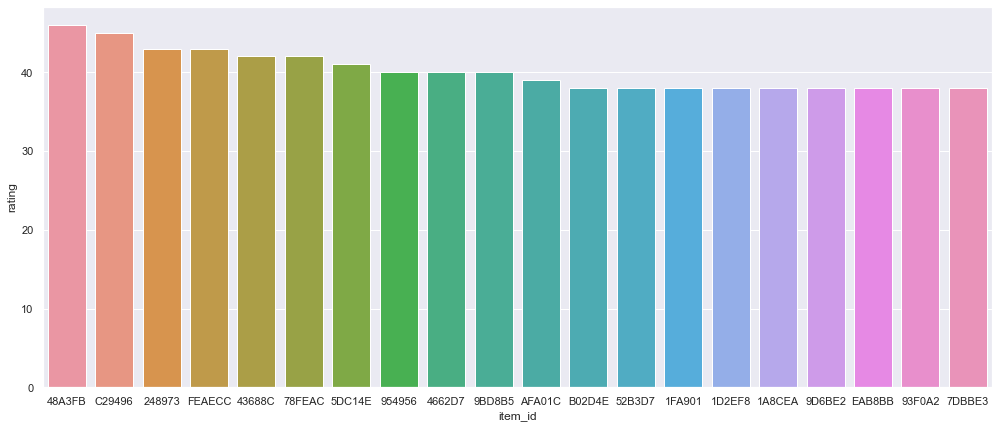

In [69]:
## Find Top-20 most popular items 
dtmp = dtrain.groupby('item_id')['rating'].count().sort_values(ascending = False)[:20]
df=pd.DataFrame(dtrain.groupby('item_id')['rating'].count().sort_values(ascending = False)[:20])
df.columns =['Count']
print(df)
plt.figure(1, figsize=(17, 7))
sns.barplot(x=df.index, y=dtmp, order=dtmp.index)
plt.show()

## Use the developed methods to predict ratings

GLB_LFM(Performance in Public Leaderboard:1.57487)

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 1.098, valid_rmse: 3.715
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.863, valid_rmse: 1.535
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.873, valid_rmse: 1.518
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.958, valid_rmse: 1.822
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.876, valid_rmse: 1.506
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.119, valid_rmse: 1.608
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.109, valid_rmse: 1.601
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.109, valid_rmse: 1.595
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.102, valid_rmse: 1.562
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.113, valid_rmse: 1.572
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.424, valid_rmse: 1.778
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.411, valid_rmse: 1.839
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.431, valid_rmse: 1.772
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.419, valid_rmse: 1.835
5-Fold

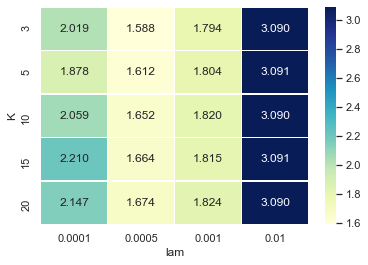

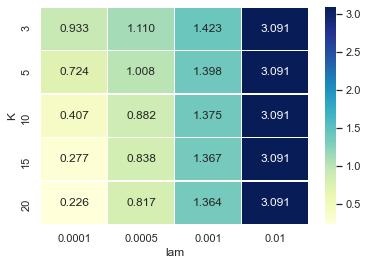

Fitting Reg-LFM: K: 3, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.266 RMSE: 2.602
Reg-LFM: ite: 1; diff: 0.285 RMSE: 1.860
Reg-LFM: ite: 2; diff: 0.242 RMSE: 1.410
Reg-LFM: ite: 3; diff: 0.145 RMSE: 1.205
Reg-LFM: ite: 4; diff: 0.022 RMSE: 1.179
Reg-LFM: ite: 5; diff: 0.008 RMSE: 1.170
Reg-LFM: ite: 6; diff: 0.005 RMSE: 1.164
Reg-LFM: ite: 7; diff: 0.003 RMSE: 1.161
Reg-LFM: ite: 8; diff: 0.002 RMSE: 1.158
Reg-LFM: ite: 9; diff: 0.002 RMSE: 1.155


In [110]:
## GLB_mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred_glb = glb_ave.predict(test_pair)
train_rating_cm = train_rating - glb_ave.predict(train_pair)

## fit GLB_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_cm)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_cm)
pred = pred_glb + shiing.predict(test_pair)
pred_rating = pred

GLB_user_mean_LMF(Performance in Public Leaderboard:1.71924)

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.810, valid_rmse: 1.391
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.808, valid_rmse: 1.388
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.805, valid_rmse: 1.347
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.798, valid_rmse: 1.417
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.809, valid_rmse: 1.378
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.970, valid_rmse: 1.301
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.986, valid_rmse: 1.281
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.979, valid_rmse: 1.285
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.978, valid_rmse: 1.271
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.978, valid_rmse: 1.255
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.219, valid_rmse: 1.383
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.230, valid_rmse: 1.345
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.219, valid_rmse: 1.370
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.238, valid_rmse: 1.373
5-Fold

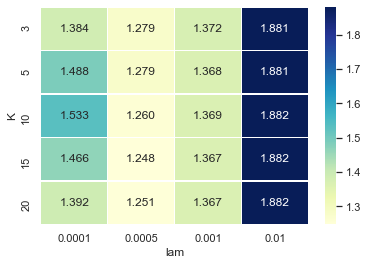

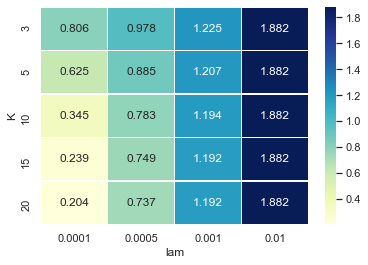

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.701 RMSE: 1.284
Reg-LFM: ite: 1; diff: 0.292 RMSE: 0.909
Reg-LFM: ite: 2; diff: 0.048 RMSE: 0.865
Reg-LFM: ite: 3; diff: 0.028 RMSE: 0.841
Reg-LFM: ite: 4; diff: 0.018 RMSE: 0.826
Reg-LFM: ite: 5; diff: 0.012 RMSE: 0.816
Reg-LFM: ite: 6; diff: 0.008 RMSE: 0.809
Reg-LFM: ite: 7; diff: 0.006 RMSE: 0.804
Reg-LFM: ite: 8; diff: 0.004 RMSE: 0.801
Reg-LFM: ite: 9; diff: 0.003 RMSE: 0.798


In [100]:
# user_mean
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
pred_user_mean = pred_glb + user_ave.predict(test_pair)

# fit GLB + user_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

GLB_item_mean_LMF(Performance in Public Leaderboard:2.49205)

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.929, valid_rmse: 1.660
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.908, valid_rmse: 1.619
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.917, valid_rmse: 1.692
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.996, valid_rmse: 2.272
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.928, valid_rmse: 1.707
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.113, valid_rmse: 1.557
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.107, valid_rmse: 1.587
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.102, valid_rmse: 1.591
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.109, valid_rmse: 1.606
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.094, valid_rmse: 1.499
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.349, valid_rmse: 1.649
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.343, valid_rmse: 1.647
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.340, valid_rmse: 1.670
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.337, valid_rmse: 1.661
5-Fold

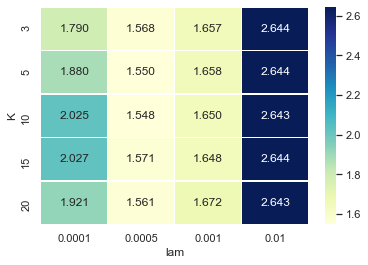

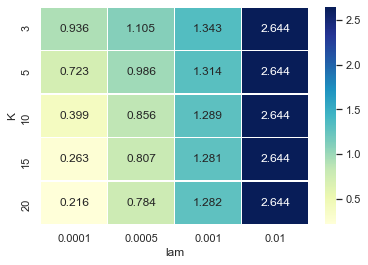

Fitting Reg-LFM: K: 10, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.612 RMSE: 1.574
Reg-LFM: ite: 1; diff: 0.315 RMSE: 1.078
Reg-LFM: ite: 2; diff: 0.057 RMSE: 1.017
Reg-LFM: ite: 3; diff: 0.034 RMSE: 0.982
Reg-LFM: ite: 4; diff: 0.024 RMSE: 0.959
Reg-LFM: ite: 5; diff: 0.017 RMSE: 0.943
Reg-LFM: ite: 6; diff: 0.013 RMSE: 0.931
Reg-LFM: ite: 7; diff: 0.010 RMSE: 0.922
Reg-LFM: ite: 8; diff: 0.008 RMSE: 0.915
Reg-LFM: ite: 9; diff: 0.006 RMSE: 0.909


In [102]:
## item mean
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
pred_item_mean = pred_glb + item_ave.predict(test_pair)

# fit GLB + item_mean + LFM_CV by residual ratings 
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

user_item_mean_LMF(Performance in Public Leaderboard:1.22190)

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.797, valid_rmse: 1.241
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.802, valid_rmse: 1.179
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.786, valid_rmse: 1.229
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.794, valid_rmse: 1.197
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.789, valid_rmse: 1.259
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.067, valid_rmse: 1.121
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.063, valid_rmse: 1.129
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.055, valid_rmse: 1.137
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.075, valid_rmse: 1.180
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.057, valid_rmse: 1.162
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.124, valid_rmse: 1.163
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.164, valid_rmse: 1.160
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.167, valid_rmse: 1.149
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.141, valid_rmse: 1.152
5-Fold

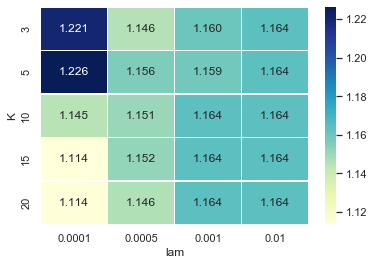

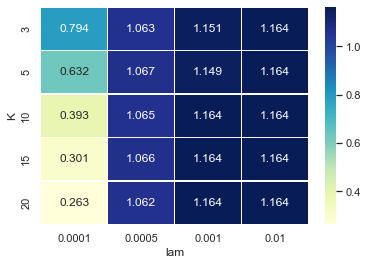

Fitting Reg-LFM: K: 15, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.923 RMSE: 1.164
Reg-LFM: ite: 1; diff: 0.000 RMSE: 1.164


In [6]:
## user_mean + item mean + LFM
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)


## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred




Set more K and lam(Performance in Public Leaderboard:1.17941)

5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.054, valid_rmse: 1.188
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.055, valid_rmse: 1.164
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.046, valid_rmse: 1.214
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.042, valid_rmse: 1.193
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.045, valid_rmse: 1.192
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.058, valid_rmse: 1.176
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.058, valid_rmse: 1.163
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.040, valid_rmse: 1.175
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.062, valid_rmse: 1.171
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.048, valid_rmse: 1.177
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 1.055, valid_rmse: 1.154
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 1.051, valid_rmse: 1.161
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 1.048, valid_rmse: 1.151
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 1.047, valid_rmse

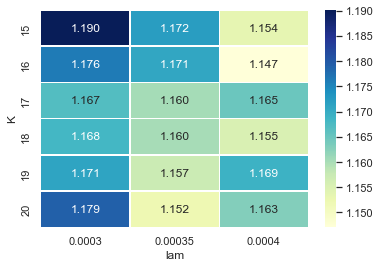

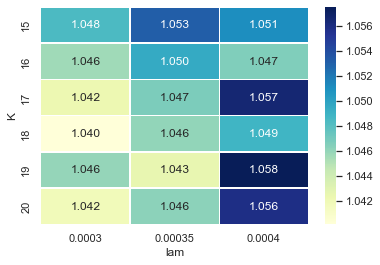

Fitting Reg-LFM: K: 16, lam: 0.00040
Reg-LFM: ite: 0; diff: 0.927 RMSE: 1.164
Reg-LFM: ite: 1; diff: 0.000 RMSE: 1.164


In [8]:
## user_mean + item mean + LFM
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)



## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [15,16,17,18,19,20],[0.0003,0.00035,0.0004]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam,iterNum=30)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred


sLMF for user_item_mean_LMF(Performance in Public Leaderboard:1.43857)

In [1]:
from sklearn.preprocessing import StandardScaler

dtrain['res_rating'] = train_rating_res

user_info = pd.DataFrame({'user_id': list(range(n_user))})
user_info = user_info.set_index('user_id')
user_info['mean'] = dtrain.groupby('user_id')['res_rating'].mean()
user_info['q1'] = dtrain.groupby('user_id')['res_rating'].quantile(.1)
user_info['q3'] = dtrain.groupby('user_id')['res_rating'].quantile(.3)
user_info['q5'] = dtrain.groupby('user_id')['res_rating'].quantile(.5)
user_info['q7'] = dtrain.groupby('user_id')['res_rating'].quantile(.7)
user_info['q9'] = dtrain.groupby('user_id')['res_rating'].quantile(.9)
## fill NAN as the column mean
user_info = user_info.fillna(user_info.mean())
user_scaler = StandardScaler()
user_info = user_scaler.fit_transform(user_info)


item_info = pd.DataFrame({'item_id': list(range(n_item))})
item_info = item_info.set_index('item_id')
item_info['mean'] = dtrain.groupby('item_id')['res_rating'].mean()
item_info['q1'] = dtrain.groupby('item_id')['res_rating'].quantile(.1)
item_info['q3'] = dtrain.groupby('item_id')['res_rating'].quantile(.3)
item_info['q5'] = dtrain.groupby('item_id')['res_rating'].quantile(.5)
item_info['q7'] = dtrain.groupby('item_id')['res_rating'].quantile(.7)
item_info['q9'] = dtrain.groupby('item_id')['res_rating'].quantile(.9)
## fill NAN as the column mean
item_info = item_info.fillna(item_info.mean())
item_scaler = StandardScaler()
item_info = item_scaler.fit_transform(item_info)

NameError: name 'train_rating_res' is not defined

In [30]:
user_info

array([[-0.21002926, -0.44897003, -0.60557075,  0.07925146,  0.46150664],
       [-0.00429153,  0.02231299, -0.08386946,  0.17809978,  0.48686177],
       [ 0.11726747, -0.31749303, -0.18781388, -0.00412349,  0.45707553],
       ...,
       [-0.54833334,  0.25794991,  0.08819271, -0.6959374 , -1.22422098],
       [-0.23806032,  0.14190889,  0.38068749, -0.02112492, -0.73086773],
       [-0.08126426,  0.46528331,  0.24447026,  0.10722004, -0.57224061]])

In [31]:
from sklearn.metrics.pairwise import cosine_similarity
user_sim = cosine_similarity(user_info)
item_sim = cosine_similarity(item_info)

In [32]:
top = 5
index_item = [np.where(train_pair[:,1] == i)[0] for i in range(n_item)]
index_user = [np.where(train_pair[:,0] == u)[0] for u in range(n_user)]
## augmented data
fake_pair, fake_rating = [], []
for u in range(n_user):
	print('UserId: %d' %u)
	top_user_tmp = user_sim[u].argsort()[-top:][::-1]
	valid_user_ind = []
	for u_tmp in top_user_tmp:
		valid_user_ind.extend(index_user[u_tmp])
	obs_item_tmp = train_pair[valid_user_ind,1]
	for i in range(n_item):
		top_item_tmp = item_sim[i].argsort()[-top:][::-1]
		valid_item_tmp = np.intersect1d(top_item_tmp, obs_item_tmp)
		if len(valid_item_tmp) == 0:
			continue
		valid_item_ind = []
		for i_tmp in valid_item_tmp:
			valid_item_ind.extend(index_item[i_tmp])
		valid_ind = np.intersect1d(valid_user_ind, valid_item_ind)
		if len(valid_ind) > 0:
			fake_pair.append([u,i])
			fake_rating.append(train_rating_res[valid_ind].mean())
fake_pair, fake_rating = np.array(fake_pair), np.array(fake_rating)

UserId: 0
UserId: 1
UserId: 2
UserId: 3
UserId: 4
UserId: 5
UserId: 6
UserId: 7
UserId: 8
UserId: 9
UserId: 10
UserId: 11
UserId: 12
UserId: 13
UserId: 14
UserId: 15
UserId: 16
UserId: 17
UserId: 18
UserId: 19
UserId: 20
UserId: 21
UserId: 22
UserId: 23
UserId: 24
UserId: 25
UserId: 26
UserId: 27
UserId: 28
UserId: 29
UserId: 30
UserId: 31
UserId: 32
UserId: 33
UserId: 34
UserId: 35
UserId: 36
UserId: 37
UserId: 38
UserId: 39
UserId: 40
UserId: 41
UserId: 42
UserId: 43
UserId: 44
UserId: 45
UserId: 46
UserId: 47
UserId: 48
UserId: 49
UserId: 50
UserId: 51
UserId: 52
UserId: 53
UserId: 54
UserId: 55
UserId: 56
UserId: 57
UserId: 58
UserId: 59
UserId: 60
UserId: 61
UserId: 62
UserId: 63
UserId: 64
UserId: 65
UserId: 66
UserId: 67
UserId: 68
UserId: 69
UserId: 70
UserId: 71
UserId: 72
UserId: 73
UserId: 74
UserId: 75
UserId: 76
UserId: 77
UserId: 78
UserId: 79
UserId: 80
UserId: 81
UserId: 82
UserId: 83
UserId: 84
UserId: 85
UserId: 86
UserId: 87
UserId: 88
UserId: 89
UserId: 90
UserId: 9

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.945, valid_rmse: 0.967
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.943, valid_rmse: 0.969
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.953, valid_rmse: 0.969
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.948, valid_rmse: 0.960
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.945, valid_rmse: 0.966
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.039, valid_rmse: 1.036
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.038, valid_rmse: 1.041
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.039, valid_rmse: 1.039
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.039, valid_rmse: 1.037
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.038, valid_rmse: 1.041
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.038, valid_rmse: 1.040
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.039, valid_rmse: 1.037
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.039, valid_rmse: 1.039
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.039, valid_rmse: 1.036
5-Fold

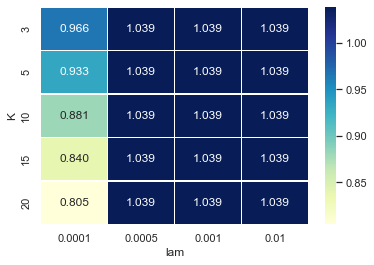

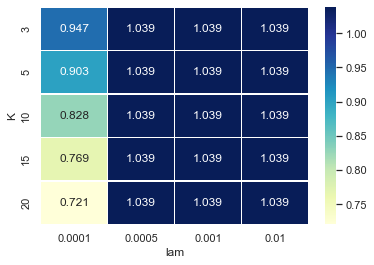

Fitting Reg-LFM: K: 20, lam: 0.00010
Reg-LFM: ite: 0; diff: 0.782 RMSE: 1.003
Reg-LFM: ite: 1; diff: 0.201 RMSE: 0.801
Reg-LFM: ite: 2; diff: 0.064 RMSE: 0.750
Reg-LFM: ite: 3; diff: 0.013 RMSE: 0.740
Reg-LFM: ite: 4; diff: 0.006 RMSE: 0.736
Reg-LFM: ite: 5; diff: 0.003 RMSE: 0.734
Reg-LFM: ite: 6; diff: 0.002 RMSE: 0.732
Reg-LFM: ite: 7; diff: 0.001 RMSE: 0.731
Reg-LFM: ite: 8; diff: 0.001 RMSE: 0.731
Reg-LFM: ite: 9; diff: 0.001 RMSE: 0.730


In [47]:
aug_pair, aug_rating_res = np.vstack((train_pair, fake_pair)), np.hstack((train_rating_res, fake_rating))

Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(aug_pair, aug_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']

sSVD=LFM(n_user, n_item, K=best_K, lam=best_lam)
sSVD.fit(aug_pair, aug_rating_res)
pred = pred + sSVD.predict(test_pair)
pred_rating = pred

item_user_mean_LMF(Performance in Public Leaderboard:1.34295)

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.870, valid_rmse: 1.502
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.394
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.856, valid_rmse: 1.493
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.873, valid_rmse: 1.438
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.402
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.997, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.989, valid_rmse: 1.269
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.995, valid_rmse: 1.208
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.001, valid_rmse: 1.217
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.005, valid_rmse: 1.232
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.186, valid_rmse: 1.243
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.186, valid_rmse: 1.237
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.275
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.250
5-Fold

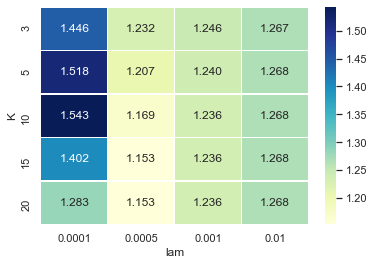

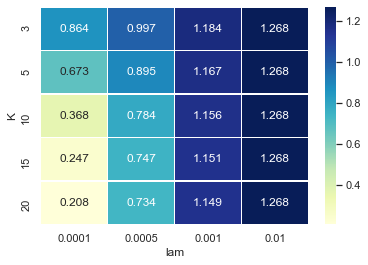

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.739 RMSE: 1.063
Reg-LFM: ite: 1; diff: 0.105 RMSE: 0.951
Reg-LFM: ite: 2; diff: 0.071 RMSE: 0.884
Reg-LFM: ite: 3; diff: 0.040 RMSE: 0.849
Reg-LFM: ite: 4; diff: 0.023 RMSE: 0.829
Reg-LFM: ite: 5; diff: 0.015 RMSE: 0.817
Reg-LFM: ite: 6; diff: 0.010 RMSE: 0.809
Reg-LFM: ite: 7; diff: 0.007 RMSE: 0.803
Reg-LFM: ite: 8; diff: 0.005 RMSE: 0.798
Reg-LFM: ite: 9; diff: 0.004 RMSE: 0.796


In [8]:
## item mean + user_mean + LFM
## item_mean 
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred = item_ave.predict(test_pair)

## user_mean
train_rating_cm = train_rating - item_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_res = train_rating_cm - user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

GLB_item_user_mean_LMF(Performance in Public Leaderboard:1.33451)

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.864, valid_rmse: 1.443
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.866, valid_rmse: 1.423
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.862, valid_rmse: 1.488
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.860, valid_rmse: 1.453
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.864, valid_rmse: 1.417
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.994, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.988, valid_rmse: 1.224
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.997, valid_rmse: 1.260
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.012, valid_rmse: 1.258
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.002, valid_rmse: 1.231
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.179, valid_rmse: 1.255
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.176, valid_rmse: 1.234
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.185, valid_rmse: 1.239
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.176, valid_rmse: 1.256
5-Fold

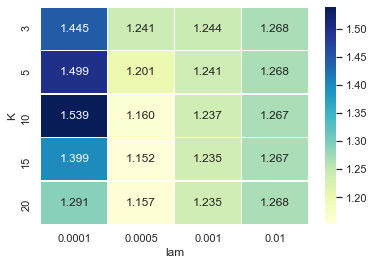

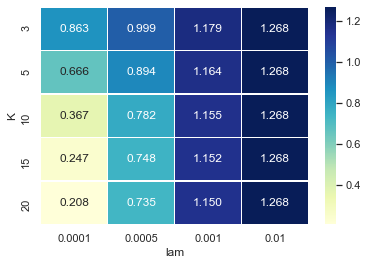

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.742 RMSE: 1.056
Reg-LFM: ite: 1; diff: 0.104 RMSE: 0.946
Reg-LFM: ite: 2; diff: 0.071 RMSE: 0.879
Reg-LFM: ite: 3; diff: 0.039 RMSE: 0.844
Reg-LFM: ite: 4; diff: 0.023 RMSE: 0.825
Reg-LFM: ite: 5; diff: 0.015 RMSE: 0.812
Reg-LFM: ite: 6; diff: 0.010 RMSE: 0.804
Reg-LFM: ite: 7; diff: 0.006 RMSE: 0.799
Reg-LFM: ite: 8; diff: 0.004 RMSE: 0.796
Reg-LFM: ite: 9; diff: 0.003 RMSE: 0.793


In [108]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# item_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_res)
pred = pred + item_ave.predict(test_pair)

# user_mean
train_rating_res -= item_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_res)
train_rating_res -= user_ave.predict(train_pair)
pred = pred + user_ave.predict(test_pair)

# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

GLB_user_item_mean_LMF(Performance in Public Leaderboard:1.57511)

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.812, valid_rmse: 1.415
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.803, valid_rmse: 1.341
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.809, valid_rmse: 1.330
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.813, valid_rmse: 1.407
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.793, valid_rmse: 1.358
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.972, valid_rmse: 1.271
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.973, valid_rmse: 1.291
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.980, valid_rmse: 1.263
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.969, valid_rmse: 1.260
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.965, valid_rmse: 1.298
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.215, valid_rmse: 1.389
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.230, valid_rmse: 1.320
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.231, valid_rmse: 1.354
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.220, valid_rmse: 1.407
5-Fold

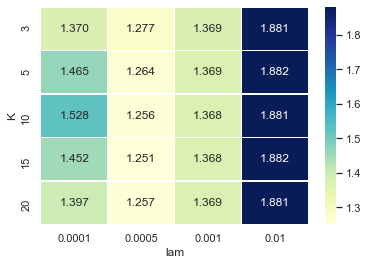

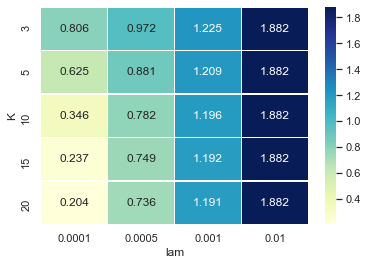

Fitting Reg-LFM: K: 15, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.704 RMSE: 1.291
Reg-LFM: ite: 1; diff: 0.290 RMSE: 0.917
Reg-LFM: ite: 2; diff: 0.046 RMSE: 0.875
Reg-LFM: ite: 3; diff: 0.029 RMSE: 0.850
Reg-LFM: ite: 4; diff: 0.021 RMSE: 0.832
Reg-LFM: ite: 5; diff: 0.014 RMSE: 0.820
Reg-LFM: ite: 6; diff: 0.009 RMSE: 0.813
Reg-LFM: ite: 7; diff: 0.007 RMSE: 0.807
Reg-LFM: ite: 8; diff: 0.005 RMSE: 0.803
Reg-LFM: ite: 9; diff: 0.004 RMSE: 0.800


In [31]:
# glb mean
glb_ave = glb_mean()
glb_ave.fit(train_rating)
pred = glb_ave.predict(test_pair)

# user_mean
train_rating_res = train_rating - glb_ave.predict(train_pair)
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating_res)
pred = pred + user_ave.predict(test_pair)

# item_mean
train_rating_res -=  user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_res)
pred = pred + item_ave.predict(test_pair)
train_rating_res -= item_ave.predict(train_pair)



# fit GLB + user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

user_mean + item_mean + user RS + LMF(Performance in Public Leaderboard:1.31635)

5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.737, valid_rmse: 1.200
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.767, valid_rmse: 1.198
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.746, valid_rmse: 1.204
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.756, valid_rmse: 1.191
5-Fold CV for K: 3; lam: 0.00010: train_rmse: 0.751, valid_rmse: 1.177
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.000, valid_rmse: 1.059
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.991, valid_rmse: 1.100
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.990, valid_rmse: 1.077
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 1.003, valid_rmse: 1.086
5-Fold CV for K: 3; lam: 0.00050: train_rmse: 0.988, valid_rmse: 1.095
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.086, valid_rmse: 1.072
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.082, valid_rmse: 1.090
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.085, valid_rmse: 1.071
5-Fold CV for K: 3; lam: 0.00100: train_rmse: 1.075, valid_rmse: 1.110
5-Fold

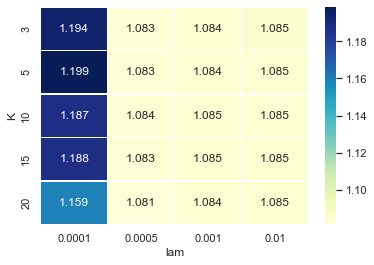

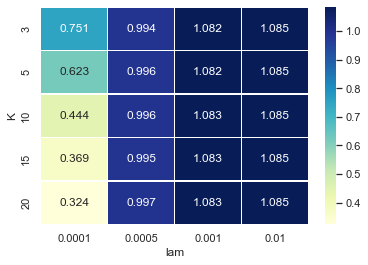

Fitting Reg-LFM: K: 20, lam: 0.00050
Reg-LFM: ite: 0; diff: 0.946 RMSE: 1.076
Reg-LFM: ite: 1; diff: 0.009 RMSE: 1.066
Reg-LFM: ite: 2; diff: 0.018 RMSE: 1.047
Reg-LFM: ite: 3; diff: 0.019 RMSE: 1.027
Reg-LFM: ite: 4; diff: 0.007 RMSE: 1.020
Reg-LFM: ite: 5; diff: 0.003 RMSE: 1.017
Reg-LFM: ite: 6; diff: 0.003 RMSE: 1.015
Reg-LFM: ite: 7; diff: 0.002 RMSE: 1.013
Reg-LFM: ite: 8; diff: 0.001 RMSE: 1.012
Reg-LFM: ite: 9; diff: 0.001 RMSE: 1.011
Reg-LFM: ite: 10; diff: 0.001 RMSE: 1.010
Reg-LFM: ite: 11; diff: 0.000 RMSE: 1.010
Reg-LFM: ite: 12; diff: 0.000 RMSE: 1.010
Reg-LFM: ite: 13; diff: 0.000 RMSE: 1.010


In [18]:
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
pred = pred + item_ave.predict(test_pair)
train_rating_cm2 = train_rating_cm - item_ave.predict(train_pair)

# fit correlation-based RS by residual ratings 
cor_user = cor_rs_user(n_user=n_user,n_item=n_item)
cor_user.fit(train_pair=train_pair, train_rating=train_rating_cm2)
pred = pred + cor_user.predict(test_pair, train_pair, train_rating_cm2, top=10)
train_rating_res = train_rating_cm2-cor_user.predict(train_pair, train_pair, train_rating_cm2, top=10)

Ks, lams = [3,5,10,15,20],[0.0001,0.0005,0.001,0.01]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam,iterNum=30)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
pred_rating = pred

user_mean + item_mean + LMF + user RS (Performance in Public Leaderboard:1.13755)

5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.046, valid_rmse: 1.171
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.049, valid_rmse: 1.171
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.043, valid_rmse: 1.167
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.039, valid_rmse: 1.209
5-Fold CV for K: 15; lam: 0.00030: train_rmse: 1.055, valid_rmse: 1.194
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.036, valid_rmse: 1.140
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.035, valid_rmse: 1.151
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.043, valid_rmse: 1.130
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.037, valid_rmse: 1.135
5-Fold CV for K: 15; lam: 0.00035: train_rmse: 1.041, valid_rmse: 1.158
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 1.049, valid_rmse: 1.147
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 1.063, valid_rmse: 1.159
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 1.042, valid_rmse: 1.142
5-Fold CV for K: 15; lam: 0.00040: train_rmse: 1.059, valid_rmse

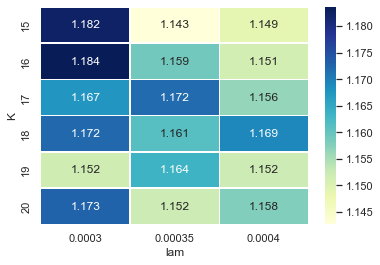

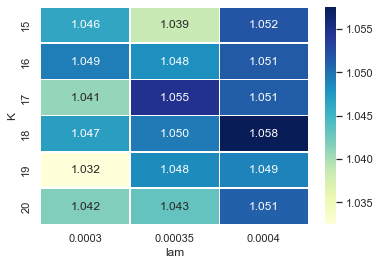

Fitting Reg-LFM: K: 15, lam: 0.00035
Reg-LFM: ite: 0; diff: 0.923 RMSE: 1.164
Reg-LFM: ite: 1; diff: 0.000 RMSE: 1.164


In [20]:
## user_mean 
user_ave = user_mean(n_user=n_user)
user_ave.fit(train_pair=train_pair, train_rating=train_rating)
pred = user_ave.predict(test_pair)

## item_mean
train_rating_cm = train_rating - user_ave.predict(train_pair)
item_ave = item_mean(n_item=n_item)
item_ave.fit(train_pair=train_pair, train_rating=train_rating_cm)
train_rating_res = train_rating_cm - item_ave.predict(train_pair)
pred = pred + item_ave.predict(test_pair)


## fit user_mean + item_mean + LFM_CV by residual ratings 
Ks, lams = [15,16,17,18,19,20],[0.0003,0.00035,0.0004]
shiing_cv = LFM_CV(n_user, n_item, cv=5, Ks=Ks, lams=lams)
shiing_cv.grid_search(train_pair, train_rating_res)
shiing_cv.plot_grid('valid')
shiing_cv.plot_grid('train')

## refit the best model, and make prediction
best_K, best_lam = int(shiing_cv.best_model['K']), shiing_cv.best_model['lam']
shiing=LFM(n_user, n_item, K=best_K, lam=best_lam,iterNum=30)
shiing.fit(train_pair, train_rating_res)
pred = pred + shiing.predict(test_pair)
train_rating_res2=train_rating_res-shiing.predict(train_pair)

# fit correlation-based RS by residual ratings 
cor_user = cor_rs_user(n_user=n_user,n_item=n_item)
cor_user.fit(train_pair=train_pair, train_rating=train_rating_res2)
pred = pred + cor_user.predict(test_pair, train_pair, train_rating_res2, top=10)
pred_rating = pred
